## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import pickle

## Data handling

In [5]:
df=pd.read_csv("FA_Leakages_MGK22nm_PVT_L_W.ms1.csv")
df.head(10)

,index,vin_a,vin_b,vin_c,temper,pvdd,lp1,lp2,lp3,lp4,...,via,vb,ib,vib,vc,ic,vic,leak_cur_dc,leakage,alter#
0,1.0,0.0,0.0,0.0,71.0,0.99,2.500000e-08,2.200000e-08,2.900000e-08,2.400000e-08,...,0.0,0.0,7.544000e-07,0.0,0.0,6.583000e-07,0.0,3.455000e-07,0.000002,1
1,2.0,0.0,0.0,0.0,121.0,0.98,2.800000e-08,3.200000e-08,3.100000e-08,2.400000e-08,...,0.0,0.0,2.193000e-06,0.0,0.0,1.191000e-06,0.0,4.911000e-07,0.000004,1
2,3.0,0.0,0.0,0.0,0.0,0.96,3.300000e-08,3.200000e-08,2.800000e-08,2.200000e-08,...,0.0,0.0,8.540000e-07,0.0,0.0,1.123000e-06,0.0,4.742000e-07,0.000003,1
3,4.0,0.0,0.0,0.0,40.0,1.08,2.800000e-08,3.200000e-08,2.700000e-08,2.700000e-08,...,0.0,0.0,3.022000e-06,0.0,0.0,1.486000e-06,0.0,8.698000e-07,0.000009,1
4,5.0,0.0,0.0,0.0,34.0,1.08,2.300000e-08,2.700000e-08,2.400000e-08,3.100000e-08,...,0.0,0.0,8.176000e-07,0.0,0.0,3.657000e-07,0.0,1.272000e-06,0.000004,1
5,6.0,0.0,0.0,0.0,7.0,1.08,2.900000e-08,3.200000e-08,2.800000e-08,3.200000e-08,...,0.0,0.0,9.630000e-07,0.0,0.0,1.258000e-06,0.0,1.259000e-06,0.000005,1
6,7.0,0.0,0.0,0.0,83.0,0.99,3.300000e-08,3.300000e-08,2.600000e-08,2.400000e-08,...,0.0,0.0,7.096000e-07,0.0,0.0,3.237000e-07,0.0,1.900000e-07,0.000002,1
7,8.0,0.0,0.0,0.0,105.0,0.91,3.200000e-08,3.300000e-08,3.000000e-08,3.300000e-08,...,0.0,0.0,1.208000e-06,0.0,0.0,8.868000e-07,0.0,4.303000e-07,0.000004,1
8,9.0,0.0,0.0,0.0,96.0,0.94,2.900000e-08,2.500000e-08,2.700000e-08,2.400000e-08,...,0.0,0.0,9.626000e-07,0.0,0.0,1.055000e-06,0.0,1.210000e-06,0.000005,1
9,10.0,0.0,0.0,0.0,105.0,1.03,2.300000e-08,2.500000e-08,3.100000e-08,2.200000e-08,...,0.0,0.0,1.312000e-06,0.0,0.0,5.457000e-07,0.0,7.998000e-07,0.000004,1


In [6]:
# remove unused columns
df = df.drop(['index'], axis=1)
df = df.drop(['alter#'], axis=1)
df = df.drop(['vsup'], axis=1)
df = df.drop(['ivdd'], axis=1)
df = df.drop(['vis'], axis=1)
df = df.drop(['va'], axis=1)
df = df.drop(['ia'], axis=1)
df = df.drop(['via'], axis=1)
df = df.drop(['vb'], axis=1)
df = df.drop(['ib'], axis=1)
df = df.drop(['vib'], axis=1)
df = df.drop(['vc'], axis=1)
df = df.drop(['ic'], axis=1)
df = df.drop(['vic'], axis=1)
df = df.drop(['leak_cur_dc'], axis=1)
df.head(10)

,vin_a,vin_b,vin_c,temper,pvdd,lp1,lp2,lp3,lp4,lp5,...,toxref_n,toxe_p,toxm_p,toxref_p,toxp_par,xj_n,xj_p,ndep_n,ndep_p,leakage
0,0.0,0.0,0.0,71.0,0.99,2.500000e-08,2.200000e-08,2.900000e-08,2.400000e-08,3.200000e-08,...,6.920000e-10,7.150000e-10,7.150000e-10,7.150000e-10,4.070000e-10,6.820000e-09,6.820000e-09,1.240000e+19,4.400000e+18,0.000002
1,0.0,0.0,0.0,121.0,0.98,2.800000e-08,3.200000e-08,3.100000e-08,2.400000e-08,3.300000e-08,...,6.130000e-10,6.620000e-10,6.620000e-10,6.620000e-10,4.170000e-10,6.820000e-09,6.820000e-09,1.230000e+19,4.280000e+18,0.000004
2,0.0,0.0,0.0,0.0,0.96,3.300000e-08,3.200000e-08,2.800000e-08,2.200000e-08,2.500000e-08,...,6.400000e-10,6.760000e-10,6.760000e-10,6.760000e-10,4.030000e-10,7.070000e-09,7.070000e-09,1.240000e+19,4.520000e+18,0.000003
3,0.0,0.0,0.0,40.0,1.08,2.800000e-08,3.200000e-08,2.700000e-08,2.700000e-08,3.300000e-08,...,6.700000e-10,6.500000e-10,6.500000e-10,6.500000e-10,3.950000e-10,7.120000e-09,7.120000e-09,1.170000e+19,4.250000e+18,0.000009
4,0.0,0.0,0.0,34.0,1.08,2.300000e-08,2.700000e-08,2.400000e-08,3.100000e-08,3.000000e-08,...,6.770000e-10,7.110000e-10,7.110000e-10,7.110000e-10,4.060000e-10,6.940000e-09,6.940000e-09,1.170000e+19,4.500000e+18,0.000004
5,0.0,0.0,0.0,7.0,1.08,2.900000e-08,3.200000e-08,2.800000e-08,3.200000e-08,2.700000e-08,...,6.330000e-10,6.920000e-10,6.920000e-10,6.920000e-10,4.030000e-10,7.050000e-09,7.050000e-09,1.080000e+19,4.600000e+18,0.000005
6,0.0,0.0,0.0,83.0,0.99,3.300000e-08,3.300000e-08,2.600000e-08,2.400000e-08,2.800000e-08,...,6.790000e-10,6.910000e-10,6.910000e-10,6.910000e-10,4.000000e-10,7.310000e-09,7.310000e-09,1.200000e+19,4.510000e+18,0.000002
7,0.0,0.0,0.0,105.0,0.91,3.200000e-08,3.300000e-08,3.000000e-08,3.300000e-08,2.900000e-08,...,6.710000e-10,6.300000e-10,6.300000e-10,6.300000e-10,3.920000e-10,7.240000e-09,7.240000e-09,1.180000e+19,4.210000e+18,0.000004
8,0.0,0.0,0.0,96.0,0.94,2.900000e-08,2.500000e-08,2.700000e-08,2.400000e-08,2.200000e-08,...,6.500000e-10,6.600000e-10,6.600000e-10,6.600000e-10,4.070000e-10,7.210000e-09,7.210000e-09,1.260000e+19,4.190000e+18,0.000005
9,0.0,0.0,0.0,105.0,1.03,2.300000e-08,2.500000e-08,3.100000e-08,2.200000e-08,2.900000e-08,...,6.910000e-10,6.700000e-10,6.700000e-10,6.700000e-10,4.010000e-10,7.210000e-09,7.210000e-09,1.190000e+19,4.080000e+18,0.000004


In [7]:
# to numpy
dataset = df.values
print(dataset.shape)

(400000, 73)


In [8]:
# removing bad rows
error_rows = []
for i in range(dataset.shape[0]):
    try:
        temp = dataset[i].astype(np.float32)
    except:
        print(i)
        error_rows.append(i)
dataset = np.delete(dataset, error_rows, axis=0)

## SVR

In [9]:
# train-test split
dataset000 = dataset[0:50000]
total_len = dataset000.shape[0]
train_length = int(0.8 * total_len)
test_length = total_len - train_length
print(total_len, train_length, test_length)

input_columns = 72
output_columns = 1

50000 40000 10000


In [11]:
np.random.shuffle(dataset000)

x_train = dataset000[:train_length, :input_columns]
y_train = dataset000[:train_length, input_columns:]

x_test = dataset000[train_length:, :input_columns]
y_test = dataset000[train_length:, input_columns:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(40000, 72) (40000, 1)
(10000, 72) (10000, 1)


In [15]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

y = y_train.reshape(-1)
X = x_train
regr = make_pipeline(StandardScaler(), SVR(C=0.8, epsilon=0.01))  # C=1.0, epsilon=0.2
regr.fit(X, y)
print(regr.score(X, y))
print(regr.score(x_test, y_test.reshape(-1)))

-12.296333342428436
-12.413539135617421


## Neural network

In [16]:
# train-test split
dataset000 = dataset[0:50000]
total_len = dataset000.shape[0]
train_length = int(0.8 * total_len)
test_length = total_len - train_length
print(total_len, train_length, test_length)

input_columns = 72
output_columns = 1

np.random.shuffle(dataset000)

x_train = dataset000[:train_length, :input_columns]
y_train = dataset000[:train_length, input_columns:]

x_test = dataset000[train_length:, :input_columns]
y_test = dataset000[train_length:, input_columns:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

50000 40000 10000
(40000, 72) (40000, 1)
(10000, 72) (10000, 1)


In [29]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        s = 32
        self.model = nn.Sequential(
            nn.LayerNorm(input_columns),
            nn.Linear(input_columns, 4*s),
            nn.LayerNorm(4*s),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(4*s, 2*s),
            nn.LayerNorm(2*s),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(2*s, 1*s),
            nn.LayerNorm(1*s),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1*s, output_columns),
            # nn.LayerNorm(output_columns),
            nn.ReLU(),
            nn.Dropout(0.2)
        )


    def forward(self, x):        
        return self.model(x)


net = Net()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train

In [30]:
net.train()

iters = 400
mini_batch_size = 256
loss_list = []

for i in range(iters):
    indices = np.random.choice(train_length, mini_batch_size)
    input = torch.tensor(x_train[indices].astype(np.float32))
    target = torch.tensor(y_train[indices].astype(np.float32))

    optimizer.zero_grad()
    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    loss_list.append(float(loss.data))
    print(i, loss_list[-1])

0 0.022175561636686325
1 0.019545013085007668
2 0.02090807445347309
3 0.012369096279144287
4 0.017888683825731277
5 0.008510645478963852
6 0.005003256257623434
7 0.004772996995598078
8 0.003969936165958643
9 0.004144121427088976
10 0.005961225368082523
11 0.0011258694576099515
12 0.0010968165006488562
13 0.0029427288100123405
14 9.481664164923131e-05
15 0.000493166851811111
16 0.00022410257952287793
17 0.00033512231311760843
18 9.933449473464862e-05
19 0.00048678848543204367
20 4.252725557307713e-05
21 0.0003193124139215797
22 2.950207439456065e-11
23 0.00015080426237545907
24 3.2189639842528095e-11
25 0.0007337512797676027
26 1.578100273036398e-05
27 2.7660870122181436e-11
28 2.6597276464590536e-11
29 2.5278869275613403e-11
30 2.395239909191993e-11
31 7.767747592879459e-05
32 2.7710115452217465e-11
33 0.0002289268304593861
34 2.773592813754e-11
35 2.8143824076787283e-11
36 2.6708229378114012e-11
37 3.126853637125393e-11
38 0.0001090492878574878
39 2.7413604372639178e-11
40 2.867903657

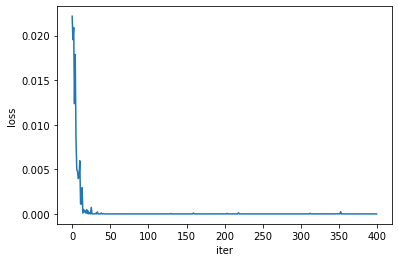

In [31]:
plt.plot(loss_list)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

## Test

In [32]:
net.eval()

with torch.no_grad():
    input = torch.tensor(x_test[[0]].astype(np.float32))
    target = torch.tensor(y_test[[0]].astype(np.float32))
    output = net(input)

    print(target)
    print(output)

tensor([[3.3310e-06]])
tensor([[0.]])


In [33]:
net.eval()

with torch.no_grad():
    iters = 50
    mini_batch_size = 256
    mse_loss_list = []
    r2_score_list = []

    for i in range(iters):
        indices = np.random.choice(test_length, mini_batch_size)
        input = torch.tensor(x_test[indices].astype(np.float32))
        target = torch.tensor(y_test[indices].astype(np.float32))

        output = net(input)
        mse_loss_list.append(criterion(output, target))
        r2_score_list.append(r2_score(target, output))

        print(i, mse_loss_list[-1], r2_score_list[-1])

0 tensor(2.5657e-11) -6.033113633480241
1 tensor(2.8136e-11) -4.497864448564199
2 tensor(2.7728e-11) -4.8182650073921485
3 tensor(2.8474e-11) -4.47027642614686
4 tensor(2.8410e-11) -4.2200028344938705
5 tensor(2.5946e-11) -5.10571684299684
6 tensor(2.6367e-11) -4.700591673369528
7 tensor(2.7982e-11) -3.662583389551222
8 tensor(2.7493e-11) -4.24463529083478
9 tensor(2.9443e-11) -4.102103754903245
10 tensor(2.6477e-11) -4.455724204836905
11 tensor(2.8484e-11) -4.792040080493775
12 tensor(2.7255e-11) -4.529806565366055
13 tensor(2.7859e-11) -4.034604576172
14 tensor(2.7421e-11) -4.6140165606133445
15 tensor(2.8115e-11) -4.324477025069148
16 tensor(2.5970e-11) -5.393733120220927
17 tensor(2.6156e-11) -5.451300259662548
18 tensor(2.7594e-11) -4.534179744738182
19 tensor(2.7841e-11) -4.701696476967104
20 tensor(2.9569e-11) -4.535134787636677
21 tensor(2.6334e-11) -4.732509808379394
22 tensor(2.4504e-11) -4.649922041986974
23 tensor(2.7099e-11) -3.988792300556808
24 tensor(2.6340e-11) -4.1780